# Group Project Report: Maternal Health Risk Classification

Members: Ruby Liu, Yu Wei Chen, Annabel Lim, Heather Jia

## Introduction

### Background Information

Depending on a number of factors, a pregnancy can be considered “high-risk”. A high-risk pregnancy means that both mother and child are more likely to have health problems, requiring special monitoring to ensure the least amount of harm. It is important to know whether a mother is high-risk, so medical professionals can take the necessary preventative measures to ensure the health of both the mother and baby. 

### Project Question

Can we use the maternal risk factor measurements (age, systolic blood pressure, diastolic blood pressure, and blood sugar level) provided in our data to predict whether someone who is pregnant is at high risk, mid-risk, or low risk of maternal mortality? 

### Data Set

We will be using the Maternal Health Risk Data Set from the UCI Machine Learning Repository. The data was collected from hospitals, community clinics, and maternal health care centres from the rural areas of Bangladesh where region-specific studies have found that 1 in 10 pregnant women have low blood glucose levels. There are columns for age, systolic blood pressure, diastolic blood pressure, blood sugar, body temperature, heart rate, and risk level.


## Methods and Results 

In [21]:
install.packages("tidymodels")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [22]:
# load libraries 
library(tidyverse)
library(tidymodels)

# set seed value
set.seed(4)

In [23]:
# data set url
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00639/Maternal%20Health%20Risk%20Data%20Set.csv"

# read data 
maternity_data <- read_csv(url) |>
    mutate(RiskLevel = as_factor(RiskLevel))
head(maternity_data)

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,130,80,15.00,98,86,high risk
35,140,90,13.00,98,70,high risk
29,90,70,8.00,100,80,high risk
30,140,85,7.00,98,70,high risk
35,120,60,6.10,98,76,low risk
23,140,80,7.01,98,70,high risk


In [24]:
# keep predictors: Age, Systolic Blood Pressure, Diastolic Blood Pressure, Blood Sugar
# target variable: Risk Level 
maternity_selected <- maternity_data |>
    select(Age, DiastolicBP, SystolicBP, BS, RiskLevel)
head(maternity_selected)

Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,80,130,15.00,high risk
35,90,140,13.00,high risk
29,70,90,8.00,high risk
30,85,140,7.00,high risk
35,60,120,6.10,low risk
23,80,140,7.01,high risk


In [25]:
set.seed(4);

# split data by 75% training, 25% testing 
maternity_split <- initial_split(maternity_selected, prop = 0.75, strata = RiskLevel) 

# training set 
maternity_train <- training(maternity_split)

# testing set
maternity_test <- testing(maternity_split)

head(maternity_train)
head(maternity_test)

Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,80,130,15.00,high risk
35,90,140,13.00,high risk
30,85,140,7.00,high risk
23,80,140,7.01,high risk
50,90,140,15.00,high risk
25,100,140,7.01,high risk


Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,70,90,8.00,high risk
23,70,130,7.01,mid risk
35,60,85,11.00,high risk
42,80,130,18.00,high risk
50,80,140,6.70,mid risk
21,65,90,7.50,low risk


In [46]:
# find proportions of labels
maternity_proportions <- maternity_train |>
    group_by(RiskLevel) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(maternity_train))

maternity_proportions

RiskLevel,n,percent
<fct>,<int>,<dbl>
high risk,204,26.84211
low risk,304,40.00000
mid risk,252,33.15789


##### Table 1. Proportions of target variable labels 

In [47]:
# find mean of each predictor
maternity_predictor_means <- maternity_train |>
    select(- RiskLevel) |>
    map_df(mean)

maternity_predictor_means

Age,DiastolicBP,SystolicBP,BS
<dbl>,<dbl>,<dbl>,<dbl>
29.95658,76.63684,113.1776,8.807539


##### Table 2. Average of each predictor

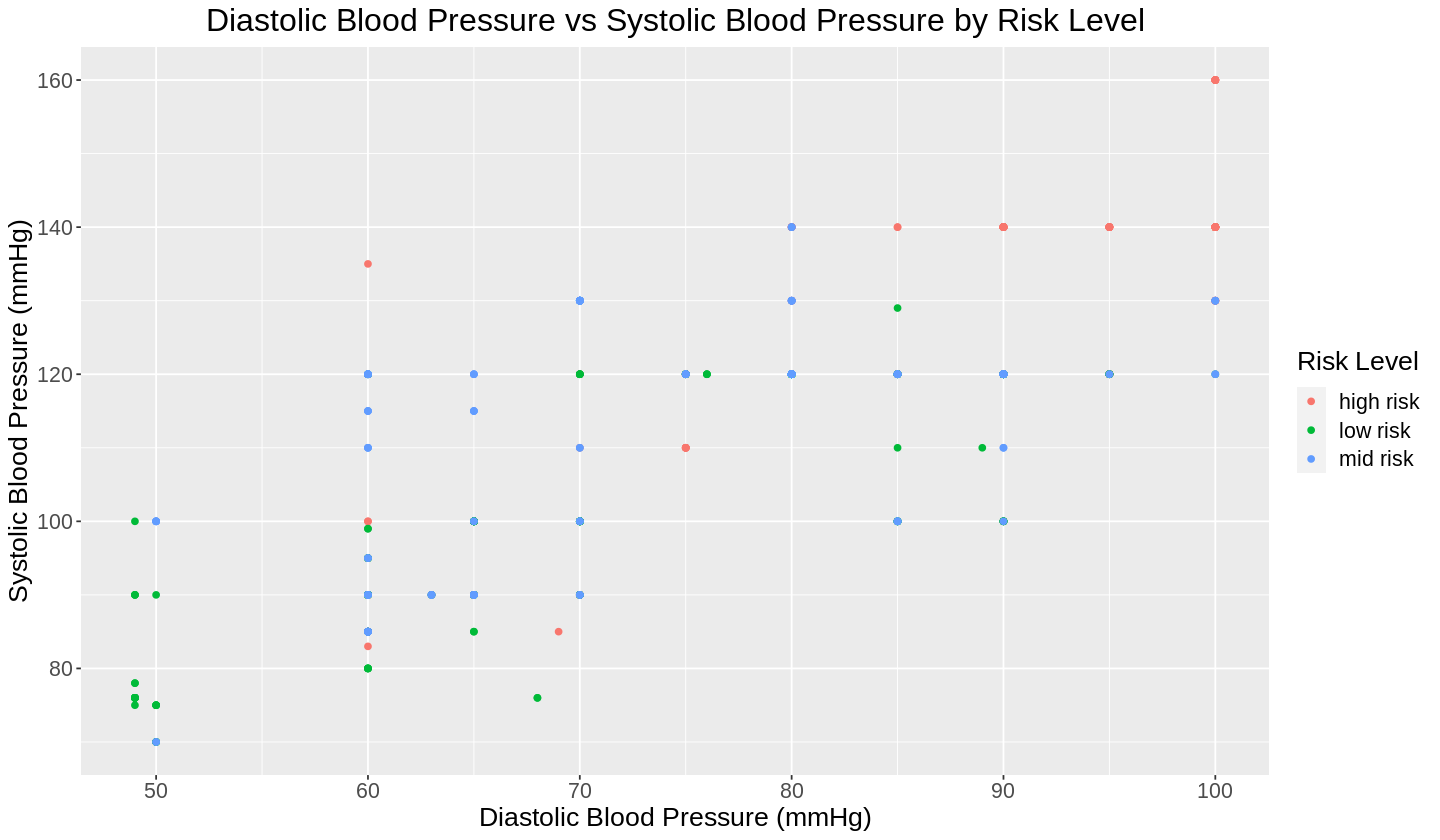

In [49]:
options(repr.plot.width = 12, repr.plot.height = 7)

# plot diastolic BP vs systolic BP, color by risk level
maternity_diastolic_vs_systolic <- maternity_train |>
    ggplot(aes(x = DiastolicBP, y = SystolicBP, color = RiskLevel)) +
        geom_point() +
        labs (x = "Diastolic Blood Pressure (mmHg)", y = "Systolic Blood Pressure (mmHg)", color = "Risk Level") +
        ggtitle("Diastolic Blood Pressure vs Systolic Blood Pressure by Risk Level") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_diastolic_vs_systolic

##### Figure 1. Preliminary exploratory data analysis: Diastolic Blood Pressure vs Systolic Blood Pressure by Risk Level

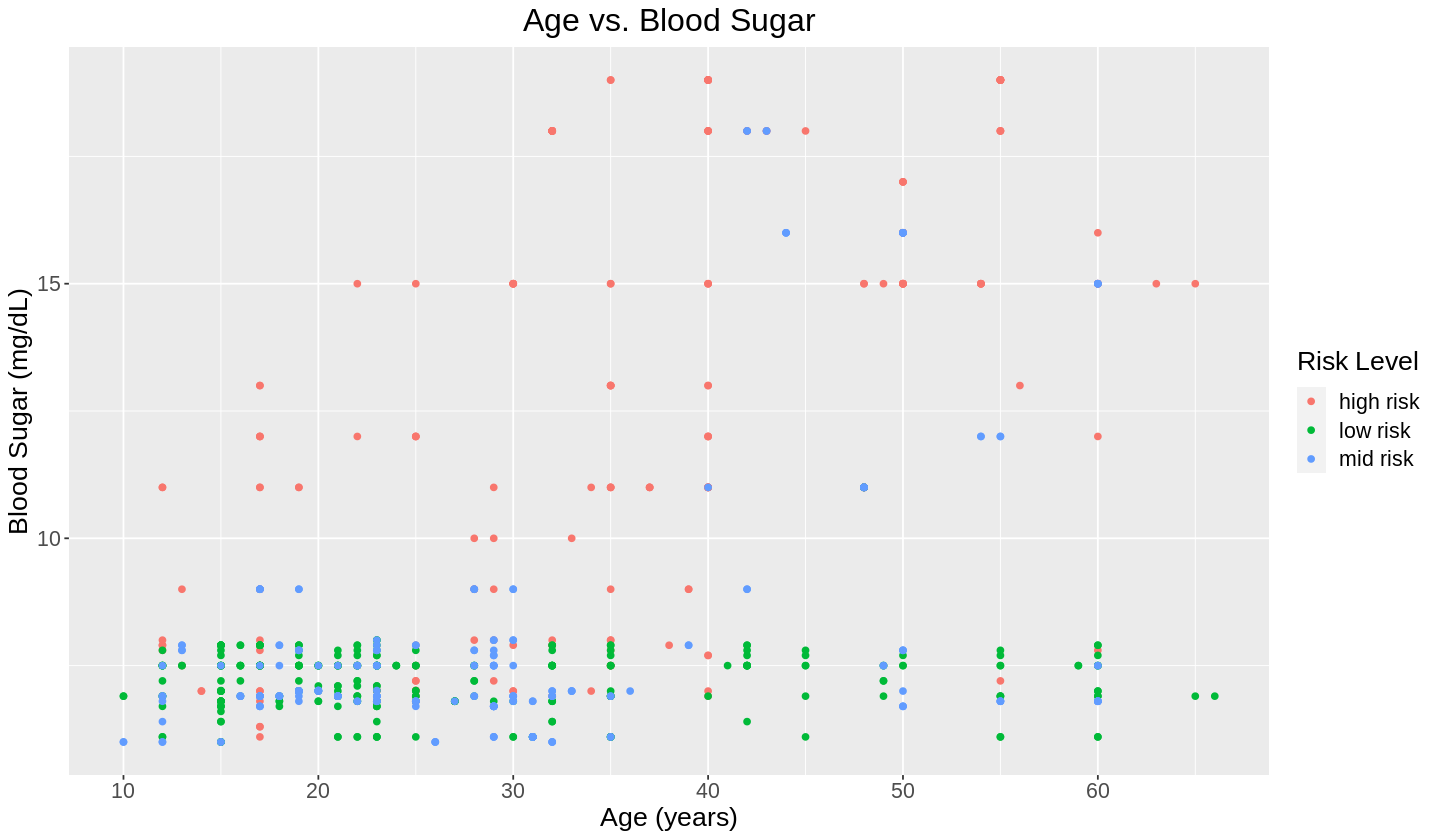

In [37]:
#plot blood sugar vs age, colour by risk level
maternity_BS_vs_Age <- maternity_train |>
    ggplot(aes(x = Age, y = BS, color = RiskLevel)) +
        geom_point() +
        labs (x = "Age (years)", y = "Blood Sugar (mg/dL)", color = "Risk Level") +
        ggtitle("Age vs. Blood Sugar") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_BS_vs_Age

##### Figure 2. Preliminary exploratory data analysis: Age vs. Blood Sugar

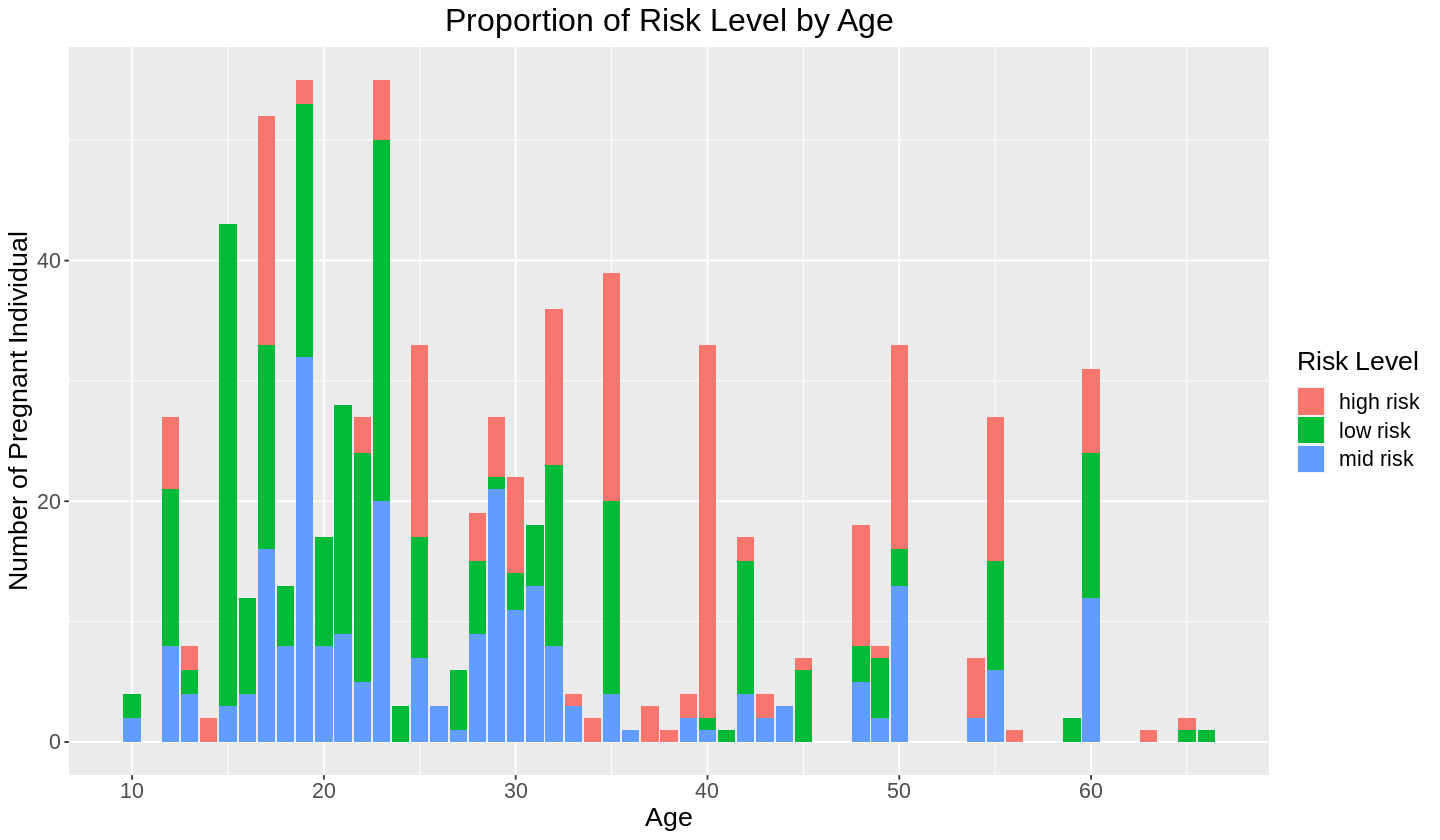

In [38]:
# plot proportion of risk level based on age 
maternity_age_vs_risk <- maternity_train |>
    ggplot(aes(x = Age, fill = RiskLevel)) +
        geom_bar() +
        labs(x = "Age", y = "Number of Pregnant Individual", fill = "Risk Level") +
        ggtitle("Proportion of Risk Level by Age") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_age_vs_risk

##### Figure 3.Preliminary exploratory data analysis: Proportion of Risk Level by Age

In [28]:
set.seed(4)

# create recipe with all predictors
maternity_recipe <- recipe(RiskLevel ~., data = maternity_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create knn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform 5 fold cross validation on training set
train_vfold <- vfold_cv(maternity_train, v=5, strata = RiskLevel) 

# create data frame where k = 1 to 10
k_vals <- tibble(neighbors = seq(from = 1, to = 10))

In [29]:
# use workflow to combine recipe + model spec
# then tune model using tune_grid and collect metrics
knn_results <- workflow() |>
    add_recipe(maternity_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = train_vfold, grid = k_vals) |>
    collect_metrics()

# get accuracy from metrics on fitted model 
accuracies <- knn_results |>
    filter(.metric == "accuracy") 

head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7750320,5,0.007321992,Preprocessor1_Model01
2,accuracy,multiclass,0.7671713,5,0.007404737,Preprocessor1_Model02
3,accuracy,multiclass,0.6974668,5,0.016865842,Preprocessor1_Model03
4,accuracy,multiclass,0.6895889,5,0.014350892,Preprocessor1_Model04
5,accuracy,multiclass,0.6619216,5,0.021355788,Preprocessor1_Model05
6,accuracy,multiclass,0.6592724,5,0.018257172,Preprocessor1_Model06


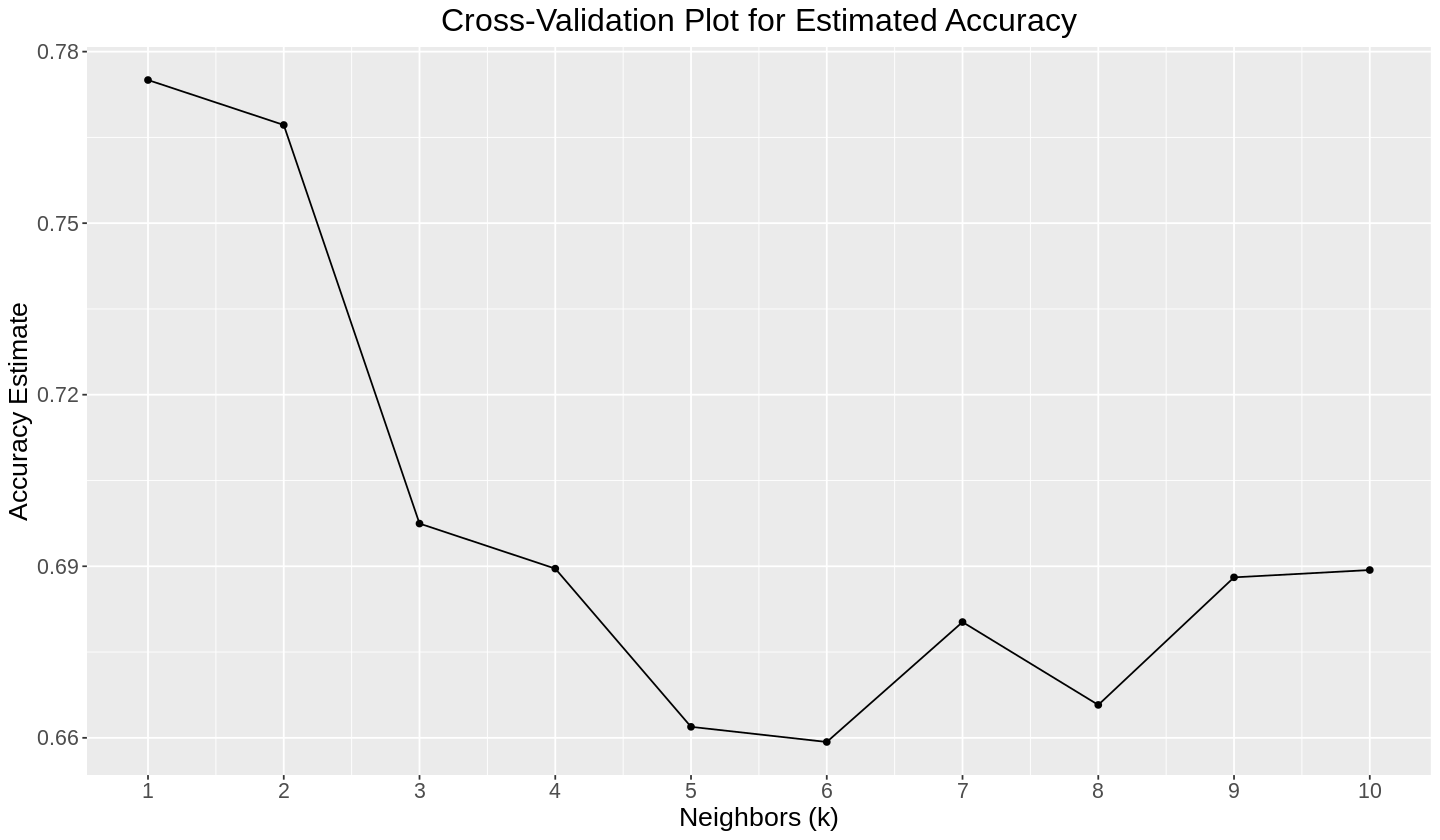

In [30]:
# plot k (neighbors) vs accuracy (mean)
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
        ggtitle("Cross-Validation Plot for Estimated Accuracy") +
        scale_x_continuous(breaks = 1:10) +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

# can estimate and view which k value may be the best
cross_val_plot

##### Figure 4. Cross-Validation Plot for Estimated Accuracy

In [45]:
# choose k = 2

# create knn model specification with chosen k
final_spec <- nearest_neighbor(weight_func = "rectangular",
                               neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

# analysis
final_results <- workflow() |>
    add_recipe(maternity_recipe) |>
    add_model(final_spec) |>
    fit(data = maternity_train) |>
    predict(maternity_test) |>
    bind_cols(maternity_test)

# extracting model's accuracy
final_accuracy <- final_results |>
    metrics(truth = RiskLevel, estimate = .pred_class) |>
    filter(.metric == "accuracy")
final_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8307087


##### Table 3. Accuracy of classifier model

In [50]:
# extracting model's confusion matrix
final_conf_mat <- final_results |>
    conf_mat(truth = RiskLevel, estimate = .pred_class)
final_conf_mat

           Truth
Prediction  high risk low risk mid risk
  high risk        61        2        5
  low risk          1       88       17
  mid risk          6       12       62

##### Table 4. Confusion matrix of model's accuracy

## Discussion

#### 4. Discuss what future questions could this lead to?

##### Question 1

As our data set is based on rural areas of Bangladesh, how different will the values of the predictor variables be for pregnant women in non-rural areas of Bangladesh and/or North America? How much would this difference influence the accuracy of our model, specifically to reduce the number of mistakes made between classifications of mid-risk and low risk? The difference in values for predictor variables might not be that different as there is only so much range a group of people can have in something like blood pressure until it is obviously abnormal. However, the proportions of risk levels between rural and non-rural data are likely to indicate the state of healthcare in those areas.

##### Question 2

With Artificial Intelligence being combined with ultrasound images, can an improvement of the model, with a higher accuracy and trained on more diverse data, be used as a cheaper, safer, more accessible, and efficient alternative to detect pregnancy risks? In countries that have less accessible health care facilities, such a model could be added to a small machine then carried around by nurses or practitioners in these areas. There would be no need to carry around a big ultrasound machine or have many of these expensive machines around. Then if the classifier were to detect a high risk, that individual could be taken to a hospital for further testing. 

##### Question 3

Will society trust Artificial Intelligence to determine if a mother and their child is at risk during pregnancy? A lot of people still dislike AI and do not like it being combined with health related fields. For instance, if the classifier were to predict a high risk, it may influence the mother to think differently about the child they are carrying. With this in mind, we could be putting the decision of the birth or death of a fetus in the hands of AI. On the other hand, because AI has the ability to process and train on so much more data (different cases of high, mid, and low risk pregnancies), the AI has seen more diverse cases than any doctor has, hence should be more accurate. These different perspectives may cause a dispute if we were to solely use such a classifier to diagnose the risk of a pregnancy. 


## References 

- *Maternal Health Risk Data Set Data Set*. (2020, December 31). UCI Machine Learning Repository. Retrieved March 12, 2023, from https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set
- Mondal, R., Sarkar, N., Karim, A. I., Numan, S. M., & Zaman, M. (2022). Pregnancy-related health status in a remote rural area of Bangladesh: results from a clinic-based cross-section of antenatal check-up visits. *Journal of Xiangya Medicine, 7*, 0. https://doi.org/10.21037/jxym-21-36
- World Health Organization: WHO. (2023, February 22). *Maternal mortality*. World Health Organization. Retrieved March 12, 2023, from https://www.who.int/news-room/fact-sheets/detail/maternal-mortality